In [1]:
# !jupyter nbconvert --to script A0Task1.ipynb 
# converts Jupyter notebook to python script 
# uncomment first line and run the cell to do so

## Task 1: Dimensionality & Distance-Based Classifiers

We work on 16×16 grayscale digits (256 features). For each class d in {0,…,9} we compute:
- the class “center” c_d = average of all training vectors belonging to class d
- a nearest-mean classifier: predict the class whose center is closest by Euclidean distance
- the between-class distance matrix D_ij = Euclidean distance between centers of class i and class j

We visualize the training set with PCA, t-SNE, and UMAP, and compare the nearest-mean classifier against k-NN (k=3) using train/test accuracy and confusion matrices.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import umap

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist

from matplotlib.colors import LogNorm
from matplotlib.patches import Patch, Rectangle

In [3]:
# Configure default plot settings
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams["axes.grid"] = False
sns.set_context("talk")

# Helper function for plots
def annotate_heatmap(ax, cm, fmt=".1f"):
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if i == j: # diagonal
                if cm[i, j] != 0.0: 
                    # highlight correct predictions in same blue color
                    ax.add_patch(plt.Rectangle((j-0.5, i-0.5), 1, 1, color='blue', zorder=0))
                    color = "white"
                else:
                    # keep empty cells white
                    ax.add_patch(plt.Rectangle((j-0.5, i-0.5), 1, 1, color='white', zorder=0))
                    color = "black"
            else:
                # choose text color based on background
                color = "white" if cm[i, j] > cm.max()/2 else "black"
            # add text annotation
            ax.text(j, i, format(cm[i, j], fmt), ha="center", va="center", color=color, fontsize=10)

## 1) Load data and sanity checks

Train/test inputs are 256-D vectors; outputs are digits 0–9. We print shapes, a short summary of features, and label counts to verify integrity.


In [4]:
# Load data
train_in = pd.read_csv("Data/train_in.csv", header=None)
train_out = pd.read_csv("Data/train_out.csv", header=None).iloc[:, 0]
test_in  = pd.read_csv("Data/test_in.csv", header=None)
test_out = pd.read_csv("Data/test_out.csv", header=None).iloc[:, 0]

# Dataset shape
print("Shapes:", train_in.shape, train_out.shape, test_in.shape, test_out.shape)

# Distribution of labels
print("Train label counts:\n", train_out.value_counts().sort_index())

# Sanity checks
assert train_in.shape[1] == 256
assert set(train_out.unique()) <= set(range(10))

Shapes: (1707, 256) (1707,) (1000, 256) (1000,)
Train label counts:
 0
0    319
1    252
2    202
3    131
4    122
5     88
6    151
7    166
8    144
9    132
Name: count, dtype: int64


## 2) Class centers and nearest-mean rule

We compute one center per digit from the **training** set only.  
Nearest-mean prediction for a sample x: compute Euclidean distance from x to each class center and choose the smallest.  
We report train/test accuracy.



In [5]:
# Compute class centroids by averaging training samples per label
centers_df = train_in.join(train_out.rename("label")).groupby("label").mean()
centers_df = centers_df.sort_index()
centers_matrix = centers_df.to_numpy()
labels_sorted = centers_df.index.to_numpy()

print("Centers matrix shape:", centers_matrix.shape)

# Classifier: assign each sample to the nearest class centroid
def nearest_mean_predict(X, centers):
    dist = cdist(X, centers, metric="euclidean")   # pairwise distances
    return dist.argmin(axis=1), dist               # predicted labels, full distance matrix

# Predictions for train/test sets
train_pred_mean, train_dists = nearest_mean_predict(train_in.values, centers_matrix)
test_pred_mean,  test_dists  = nearest_mean_predict(test_in.values,  centers_matrix)

# Evaluate nearest-mean classifier
train_acc_mean = np.mean(train_pred_mean == train_out.values)
test_acc_mean  = np.mean(test_pred_mean  == test_out.values)

print(f"Nearest-Mean accuracy - Train: {train_acc_mean:.3f} | Test: {test_acc_mean:.3f}")

Centers matrix shape: (10, 256)
Nearest-Mean accuracy - Train: 0.864 | Test: 0.804


## 3) Between-class distance matrix and difficult pairs

D_ij = Euclidean distance between the center of class i and the center of class j.  
Small D_ij indicates classes that are likely to be confused by the nearest-mean classifier.  
We show a heatmap of D and list the 10 closest class pairs.


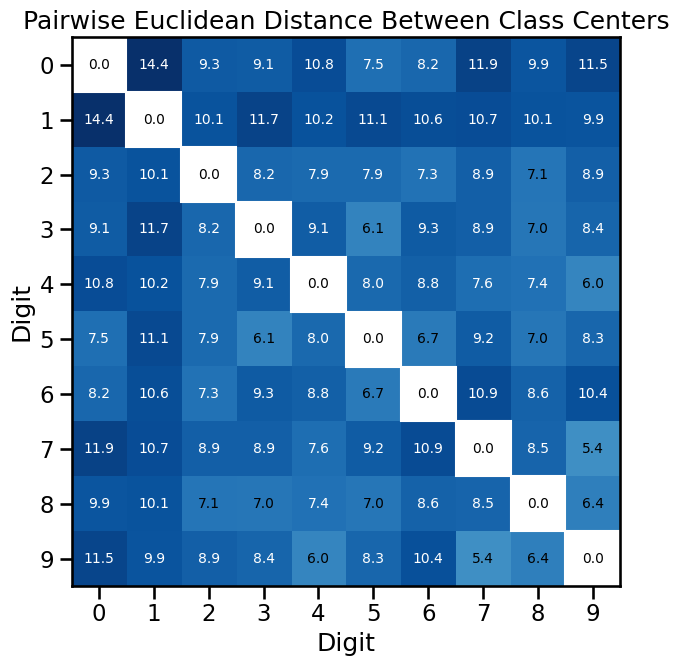

Closest 10 class-center pairs:
7 vs 9 — dist=5.43
4 vs 9 — dist=6.01
3 vs 5 — dist=6.12
8 vs 9 — dist=6.40
5 vs 6 — dist=6.70
5 vs 8 — dist=6.97
3 vs 8 — dist=7.02
2 vs 8 — dist=7.08
2 vs 6 — dist=7.33
4 vs 8 — dist=7.38


In [6]:
# Compute pairwise Euclidean distances between class centroids
center_distances = cdist(centers_matrix, centers_matrix, metric="euclidean")

# Visualize centroid distances as a heatmap (log-scaled for contrast)
fig, ax = plt.subplots(figsize=(8, 7))
im = ax.imshow(center_distances, cmap='Blues', norm=LogNorm(vmin=1, vmax=center_distances.max()))
ax.set_title("Pairwise Euclidean Distance Between Class Centers")
ax.set_xlabel("Digit")
ax.set_ylabel("Digit")
ax.set_xticks(range(len(labels_sorted)))
ax.set_yticks(range(len(labels_sorted)))
ax.set_xticklabels(labels_sorted)
ax.set_yticklabels(labels_sorted)
annotate_heatmap(ax, center_distances, fmt=".1f")
plt.tight_layout()
plt.show()

# List and sort unique centroid pairs by distance (ascending)
pairs = [(i, j, center_distances[i, j])
         for i in range(len(labels_sorted))
         for j in range(i+1, len(labels_sorted))]
pairs_sorted = sorted(pairs, key=lambda x: x[2])

# Report the 10 closest class-center pairs
print("Closest 10 class-center pairs:")
for i, (a, b, d) in enumerate(pairs_sorted[:10], 1):
    print(f"{labels_sorted[a]} vs {labels_sorted[b]} — dist={d:.2f}")


## 4) 2D visualizations: PCA, t-SNE, UMAP

We visualize the training set with three projections:
- PCA: linear projection that preserves global variance structure
- t-SNE: emphasizes local neighborhoods and cluster separation
- UMAP: manifold learning that balances local and global structure

All plots color points by digit label and use fixed random seeds for reproducibility.


c:\Users\matis\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


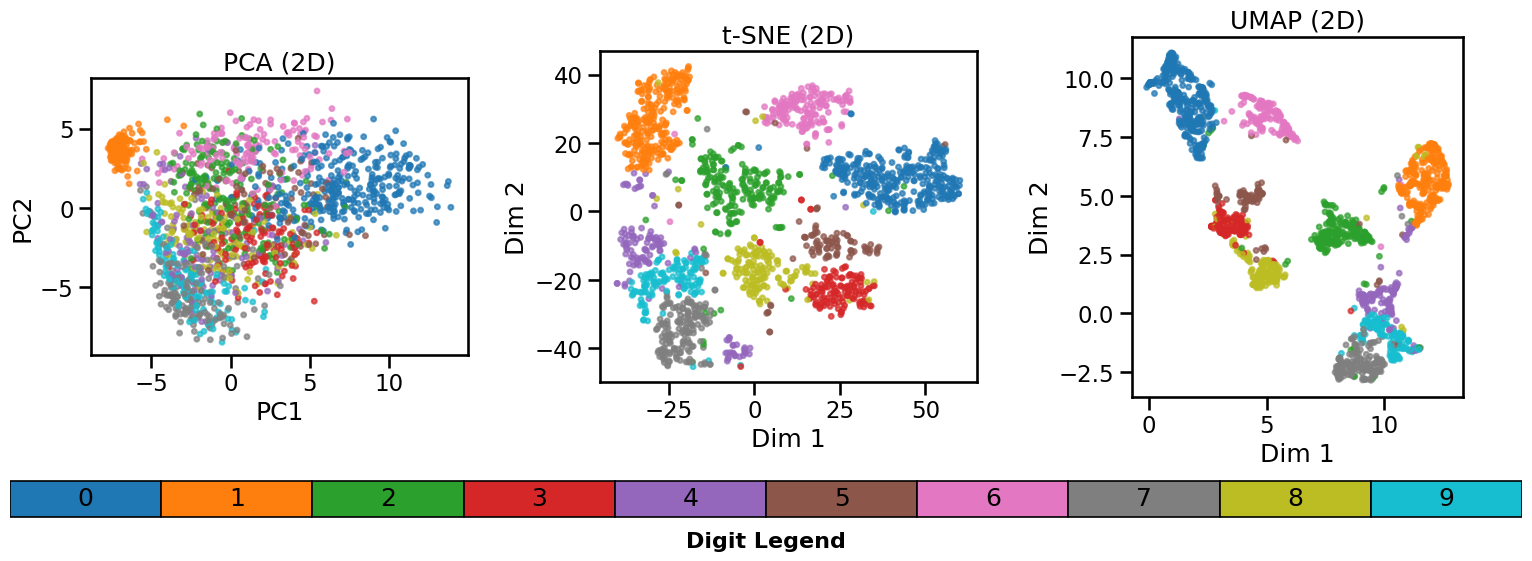

In [7]:
# Dimensionality reduction: project high-dimensional inputs to 2D
pca = PCA(n_components=2, random_state=123)
train_in_pca = pca.fit_transform(train_in)

tsne = TSNE(n_components=2, random_state=123, init="pca", learning_rate="auto")
train_in_tsne = tsne.fit_transform(train_in)

umap_reducer = umap.UMAP(n_components=2, random_state=123)
train_in_umap = umap_reducer.fit_transform(train_in)

cmap = plt.get_cmap("tab10")

# Compare PCA, t-SNE, and UMAP side-by-side
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].scatter(train_in_pca[:, 0], train_in_pca[:, 1],
                c=train_out.values, cmap="tab10", vmin=0, vmax=9, alpha=0.7, s=12)
axes[0].set_title("PCA (2D)")
axes[0].set_xlabel("PC1")
axes[0].set_ylabel("PC2")
axes[0].set_aspect('equal')

axes[1].scatter(train_in_tsne[:, 0], train_in_tsne[:, 1],
                c=train_out.values, cmap="tab10", vmin=0, vmax=9, alpha=0.7, s=12)
axes[1].set_title("t-SNE (2D)")
axes[1].set_xlabel("Dim 1")
axes[1].set_ylabel("Dim 2")
axes[1].set_aspect('equal')

axes[2].scatter(train_in_umap[:, 0], train_in_umap[:, 1],
                c=train_out.values, cmap="tab10", vmin=0, vmax=9, alpha=0.7, s=12)
axes[2].set_title("UMAP (2D)")
axes[2].set_xlabel("Dim 1")
axes[2].set_ylabel("Dim 2")
axes[2].set_aspect('equal')

for ax in axes:
    ax.set_adjustable('box')

plt.subplots_adjust(bottom=0.28, wspace=0.35)

# Add legend bar with digit-to-color mapping
bar_ax = fig.add_axes([0.08, 0.05, 0.84, 0.12])
bar_ax.set_xlim(0, 1)
bar_ax.set_ylim(0, 1)
bar_ax.axis("off")

w = 1/10
y0, h = 0.25, 0.5
for i in range(10):
    x0 = i * w
    bar_ax.add_patch(Rectangle((x0, y0), w, h, facecolor=cmap(i), edgecolor="black", linewidth=1.2))
    bar_ax.text(x0 + w/2, y0 + h/2, str(i), ha="center", va="center", fontsize=18)

bar_ax.text(0.5, 0.05, "Digit Legend", ha="center", va="top", fontsize=16, weight="bold", clip_on=False)

plt.show()

## 5) Compare classifiers: Nearest-Mean vs k-NN (k=3)

We train k-NN on the training set and evaluate both methods on train and test.  
We report overall accuracy and show matrices.


k-NN (k=3) accuracy - Train: 0.979 | Test: 0.914
Nearest-Mean accuracy - Train: 0.864 | Test: 0.804


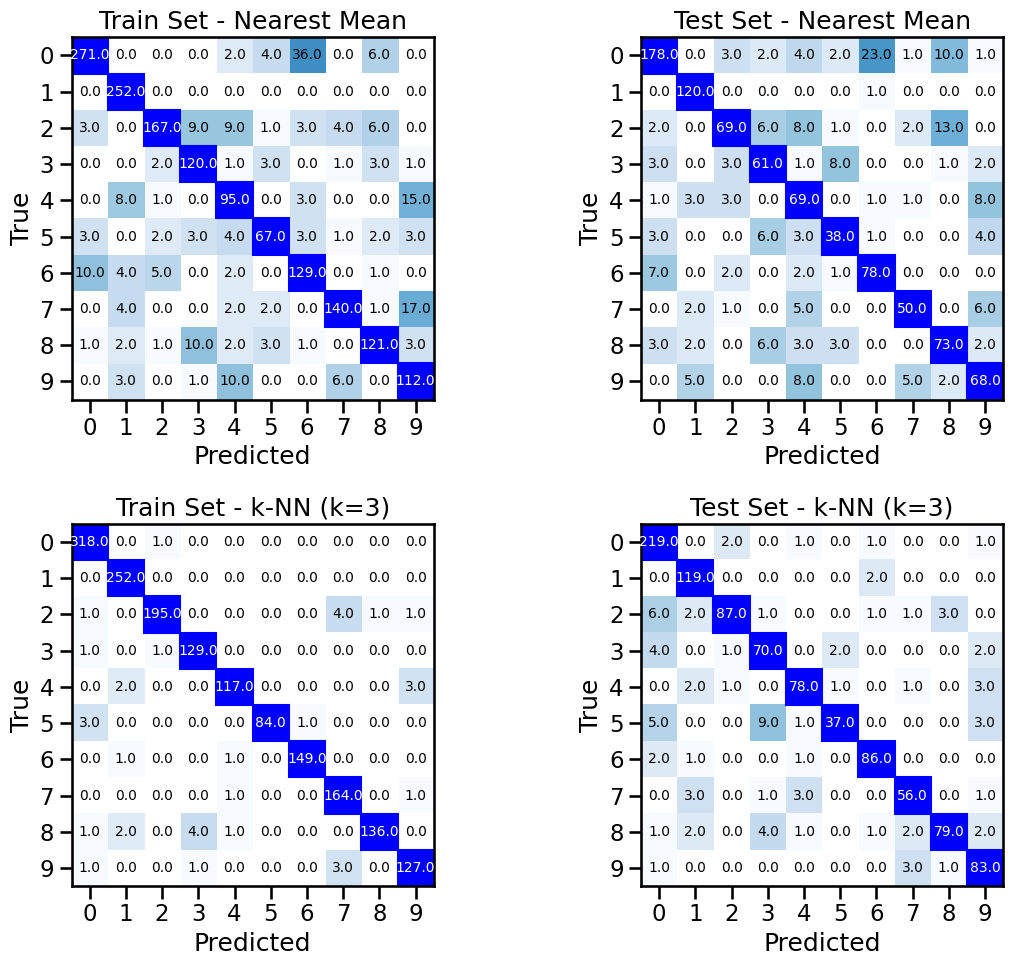

In [8]:
# Train a k-NN classifier (k=3) and evaluate alongside Nearest-Mean
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(train_in.values, train_out.values)

# Predictions
train_pred_knn = knn.predict(train_in.values)
test_pred_knn  = knn.predict(test_in.values)

# Accuracies
train_acc_knn = np.mean(train_pred_knn == train_out.values)
test_acc_knn  = np.mean(test_pred_knn  == test_out.values)

print(f"k-NN (k=3) accuracy - Train: {train_acc_knn:.3f} | Test: {test_acc_knn:.3f}")
print(f"Nearest-Mean accuracy - Train: {train_acc_mean:.3f} | Test: {test_acc_mean:.3f}")

# Confusion matrices (counts)
cm_train_mean = confusion_matrix(train_out.values, train_pred_mean, labels=range(10))
cm_test_mean  = confusion_matrix(test_out.values,  test_pred_mean,  labels=range(10))
cm_train_knn  = confusion_matrix(train_out.values, train_pred_knn,  labels=range(10))
cm_test_knn   = confusion_matrix(test_out.values,  test_pred_knn,   labels=range(10))

# Confusion matrices (row-normalized = per-true-class rates)
cm_train_mean_norm = confusion_matrix(train_out.values, train_pred_mean, labels=range(10), normalize="true")
cm_test_mean_norm  = confusion_matrix(test_out.values,  test_pred_mean,  labels=range(10), normalize="true")
cm_train_knn_norm  = confusion_matrix(train_out.values, train_pred_knn,  labels=range(10), normalize="true")
cm_test_knn_norm   = confusion_matrix(test_out.values,  test_pred_knn,   labels=range(10), normalize="true")

# Visualize raw-count confusion matrices for both models and splits
fig, axs = plt.subplots(2, 2, figsize=(12,10))

for ax in axs.flat:
    ax.set_xticks(range(10))
    ax.set_yticks(range(10))
    ax.set_xticklabels(range(0, 10))
    ax.set_yticklabels(range(0, 10))

im0 = axs[0,0].imshow(cm_train_mean, cmap='Blues', norm=LogNorm(vmin=1, vmax=cm_train_mean.max()))
axs[0,0].set_title("Train Set - Nearest Mean")
axs[0,0].set_xlabel("Predicted")
axs[0,0].set_ylabel("True")
annotate_heatmap(axs[0,0], cm_train_mean)

im1 = axs[0,1].imshow(cm_test_mean, cmap='Blues', norm=LogNorm(vmin=1, vmax=cm_test_mean.max()))
axs[0,1].set_title("Test Set - Nearest Mean")
axs[0,1].set_xlabel("Predicted")
axs[0,1].set_ylabel("True")
annotate_heatmap(axs[0,1], cm_test_mean)

im2 = axs[1,0].imshow(cm_train_knn, cmap='Blues', norm=LogNorm(vmin=1, vmax=cm_train_knn.max()))
axs[1,0].set_title("Train Set - k-NN (k=3)")
axs[1,0].set_xlabel("Predicted")
axs[1,0].set_ylabel("True")
annotate_heatmap(axs[1,0], cm_train_knn)

im3 = axs[1,1].imshow(cm_test_knn, cmap='Blues', norm=LogNorm(vmin=1, vmax=cm_test_knn.max()))
axs[1,1].set_title("Test Set - k-NN (k=3)")
axs[1,1].set_xlabel("Predicted")
axs[1,1].set_ylabel("True")
annotate_heatmap(axs[1,1], cm_test_knn)

plt.tight_layout()
plt.show()